In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, accuracy_score, roc_auc_score, recall_score
from sklearn.dummy import DummyClassifier

# Question 1: data preparation

Before we can detect fraud, we must clean and prepare our data. This step ensures we have a well-structured dataset for modeling.

- Load the dataset and inspect it for missing values, duplicate records, and inconsistencies.
- Separate the dataset into features (X) and target variable (y), where y represents fraud labels (0 = not fraud, 1 = fraud).
- Split the data into training (80%) and testing (20%) sets using `train_test_split()`.

## Checking the data

In [2]:
df = pd.read_csv('./data/financial_data_log.csv')
print('Shape:', df.shape)
df.head()

Shape: (20000, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,615,TRANSFER,56510.50,C956959892,56510.50,0.00,C582952352,0.0,0.00,1,0
1,714,TRANSFER,10000000.00,C131412689,10390763.24,390763.24,C1846567377,0.0,0.00,1,0
2,324,TRANSFER,21580.37,C765450059,21580.37,0.00,C125935569,0.0,0.00,1,0
3,668,CASH_OUT,1576531.53,C2000069930,1576531.53,0.00,C1345448010,0.0,1576531.53,1,0
4,499,TRANSFER,488243.65,C2117568077,488243.65,0.00,C1238599279,0.0,0.00,1,0


Check missing values

In [3]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Check duplicates

In [4]:
df[df.duplicated(keep=False)]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
417,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
731,702,TRANSFER,3171085.59,C1892216157,3171085.59,3171085.59,C1308068787,0.0,0.0,1,1
1356,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
1387,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
1388,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
1396,702,TRANSFER,3171085.59,C1892216157,3171085.59,3171085.59,C1308068787,0.0,0.0,1,1


Note: there are duplicates.

In [5]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

## Feature engineering

I notice the nameDest contain information whether the recipient is a customer or a merchant. If nameDest starts with C, then it's customer; otherwise (if it starts with M), then it's merchant. Meanwhile, nameOrig only contain customers, so it's useless as a feature.

## Taking the logarithm values

I found that the numerical columns contain very skewed values. So I will take the logarithms.

## Handling problems

There are also columns containing names: nameOrig and nameDest. I will drop them.

In [6]:
log_values = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

df_clean = df.copy()
df_clean = df_clean.drop_duplicates()
df_clean['isDestMerchant'] = df_clean['nameDest'].str[0] == 'M'
df_clean = df_clean.drop(['nameOrig', 'nameDest'], axis=1)
df_clean[log_values] = np.log(df_clean[log_values] + 1e-6)
df_clean.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isDestMerchant
0,615,TRANSFER,10.942182,10.942182,-13.815511,-13.815511,-13.815511,1,0,False
1,714,TRANSFER,16.118096,16.156428,12.875857,-13.815511,-13.815511,1,0,False
2,324,TRANSFER,9.979539,9.979539,-13.815511,-13.815511,-13.815511,1,0,False
3,668,CASH_OUT,14.270738,14.270738,-13.815511,-13.815511,14.270738,1,0,False
4,499,TRANSFER,13.098570,13.098570,-13.815511,-13.815511,-13.815511,1,0,False


In [7]:
df_clean.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
isDestMerchant       bool
dtype: object

## Splitting the data

In [9]:
df_train, df_non_train = train_test_split(df_clean, stratify=df_clean['isFraud'], train_size=0.7, random_state=42)
df_valid, df_test = train_test_split(
    df_non_train,
    stratify=df_non_train['isFraud'],
    train_size=0.5, random_state=50
)

print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)

(13997, 10)
(3000, 10)
(3000, 10)


In [10]:
def split_Xy(df: pd.DataFrame, target_col: str) -> tuple[pd.DataFrame, pd.Series]:
    y = df[target_col].copy()
    X = df.drop(target_col, axis=1).copy()
    return X, y

In [11]:
target_col = 'isFraud'
X_train, y_train = split_Xy(df_train, target_col)
X_valid, y_valid = split_Xy(df_valid, target_col)
X_test, y_test = split_Xy(df_test, target_col)

# Question 2: EDA

Understanding the dataset is crucial before applying any model. EDA helps us identify patterns, correlations, and potential outliers that could indicate fraudulent behavior.

- **Univariate or Bivariate Analysis**: Use 8 histograms and 7 boxplots with categories to check feature distributions.
- **Multivariate Analysis**: Use 2 scatter plots and correlation matrices to analyze feature relationships.
- **Outlier Detection**: Identify extreme values that may indicate fraud.
- **Provide at least 4 key insights from the EDA** that could help in fraud detection.



We'll create box plot for columns amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, and newbalanceDest, with isFraud as the hue. We'll also create histograms for those numerical variables.

For type and isFlaggedFraud we will create count plot.

## Numerical variables

In [12]:
num_vars = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

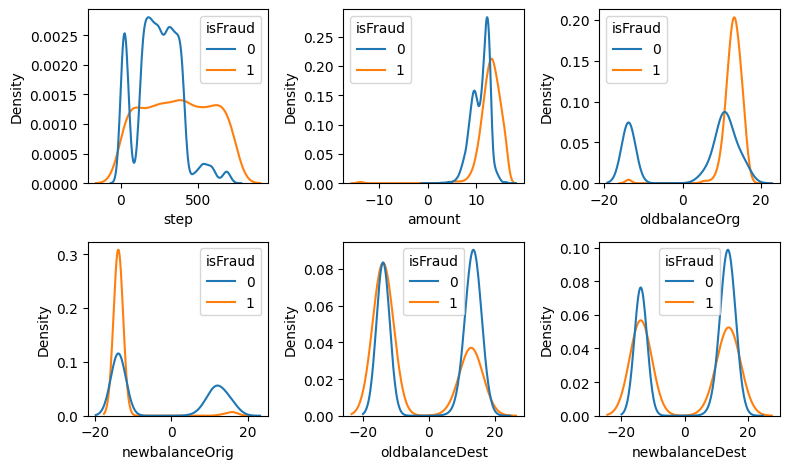

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(8)
axes = axes.flatten()

for i,var in enumerate(num_vars):
    sns.kdeplot(df_train, x=var, ax=axes[i], hue='isFraud', common_norm=False)
plt.tight_layout()

Observations: frauds appear to occur on rows with large oldbalanceOrg and zero newbalanceOrig. In other words, it occur on accounts that "cash out" their balance. How often? Let's see:

In [14]:
df_train[(df_train['oldbalanceOrg'] > 0) & (df_train['newbalanceOrig'] < 0)]['isFraud'].mean()

0.23483903169453457

It occurs 23.5% of the times on such cases.

I also notice that "step" distribution seems to follow normal distribution for frauds:

Text(0.5, 1.0, 'Frauds')

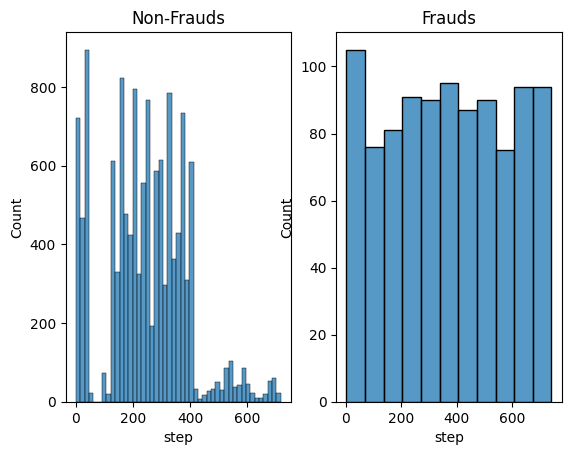

In [15]:
fig, axes = plt.subplots(ncols=2)
sns.histplot(df_train.query('isFraud==0'), x='step', ax=axes[0])
sns.histplot(df_train.query('isFraud==1'), x='step', ax=axes[1])

axes[0].set_title('Non-Frauds')
axes[1].set_title('Frauds')

It seems step>400 occur rarely on non-frauds. Can we use this to detect frauds?

In [16]:
df_train[df_train['step'] > 400]['isFraud'].mean()

0.2718505123568415

It seems so. Fraud occur 27% of the time for step>400.

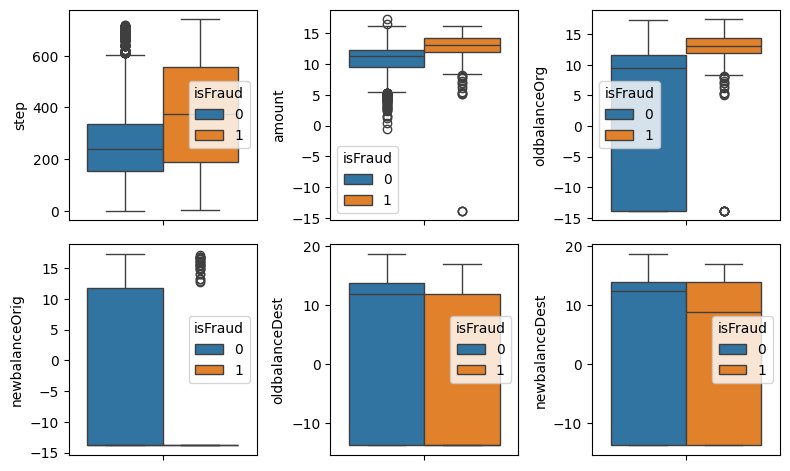

In [17]:
fig, axes = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(8)
axes = axes.flatten()

for i,var in enumerate(num_vars):
    sns.boxplot(df_train, y=var, hue='isFraud', ax=axes[i])
plt.tight_layout()

Observations:

- variables "step", "amount", and "oldbalanceOrg" appear to have higher median for frauds.
- newbalanceOrig is almost always zero for frauds.
- oldbalanceDest and newbalanceDest appear to have no predictive power.

## Categorical variables

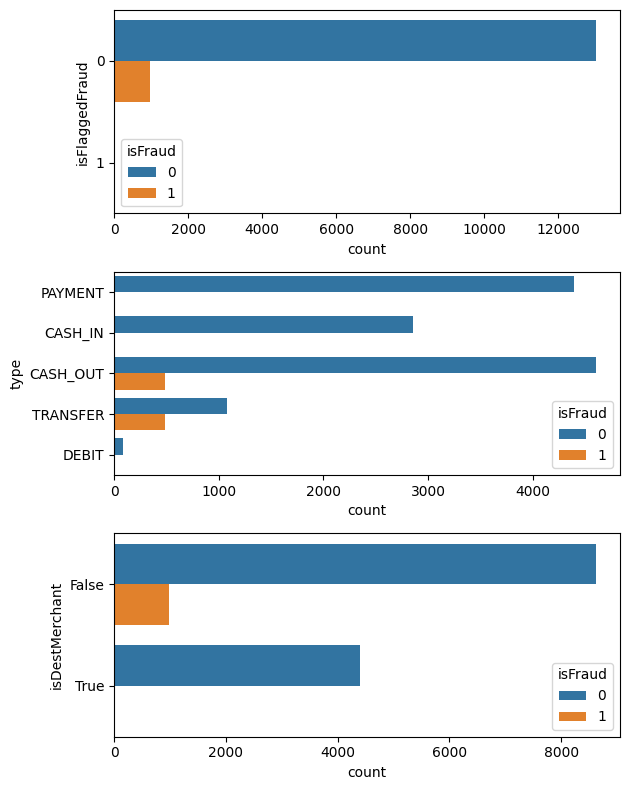

In [18]:
fig, axes = plt.subplots(nrows=3)
fig.set_figheight(8)

sns.countplot(df_train, y='isFlaggedFraud', hue='isFraud', ax=axes[0])
sns.countplot(df_train, y='type', hue='isFraud', ax=axes[1])
sns.countplot(df_train, y='isDestMerchant', hue='isFraud', ax=axes[2])

plt.tight_layout()

Observation: 

isFlaggedFraud is very rare.

Fraud only occur for CASH_OUT and TRANSFER transactions. How often do they occur?

In [19]:
df_train[df_train['type'].isin(['CASH_OUT', 'TRANSFER'])]['isFraud'].mean()

0.14678072940117065

Fraud occur 14.7% of the time for those transactions.

Another observation: fraud only occur for transaction with customer destination (not merchant). How often do they occur?

In [20]:
df_train[~df_train['isDestMerchant']]['isFraud'].mean()

0.1018962283809127

Fraud occur 10.2% of the time for those rows.

As it turns out, cash_out and transfer transactions only occur for transactions with customer destination. So isDestMerchant is redundant. See:

In [21]:
df_train[df_train['type'].isin(['CASH_OUT', 'TRANSFER'])]['isDestMerchant'].any()

False

## Conclusions

From the above analysis, we can make these conclusions regarding fraudulent transactions:

1. They have large step values
2. Often occur on "emptying" transactions (positive oldbalanceOrg and zero newbalanceOrig)
3. Has larger transaction amount
4. _Only_ occur in "cash_out" and "transfer" transaction types

# Question 3: WOE

Weight of Evidence (WOE) is a technique used to transform categorical variables into numerical values based on their relationship with fraud likelihood. WOE measures how much more or less likely a particular category is to be associated with fraud compared to non-fraud.

Create WOE for fraud analytics case with the following steps:
- Create categorical variable from numerical variable using binning method.
- Compute WOE values for each category in that variable using the WOE formula.
- Label the strength of information using IV (Information Value) using 3 categories: **[strong, weak, very low]**.
- Based on this result, suggest what variables can be used to detect fraudulent cases.

In [22]:
df_train_bin = df_train.copy()
for var in num_vars:
    df_train_bin[var + '_bin'] = pd.qcut(df_train_bin[var], q=4, duplicates='drop')
    df_train_bin = df_train_bin.drop(var, axis=1)

In [23]:
crosstabs = {}
for var in df_train_bin.columns:
    if var == 'isFraud':
        continue
    crosstabs[var] = pd.crosstab(df_train_bin[var], df_train_bin['isFraud'], margins=True)

In [24]:
from IPython.display import display, Markdown

In [25]:
WOEs = {}
IVs = {}

for var,crosstab in crosstabs.items():
    # Calculate % Good
    crosstab['p_good'] = crosstab[0]/crosstab[0]['All']

    # Calculate % Bad
    crosstab['p_bad'] = crosstab[1]/crosstab[1]['All']

    # Calculate the WOE
    crosstab['WOE'] = np.log(crosstab['p_good']/(crosstab['p_bad'] + 1e-6) + 1e6)  # add 1e-6 to prevent 0 division and log
    
    # Calculate the contribution value for IV
    crosstab['contribution'] = (crosstab['p_good']-crosstab['p_bad'])*crosstab['WOE']
    
    # Calculate the IV
    IV = crosstab['contribution'][:-1].sum()
    WOEs[var] = crosstab
    IVs[var] = IV

    display(crosstab)

isFraud,0,1,All,p_good,p_bad,WOE,contribution
type,,,,,,,
CASH_IN,2854,0,2854,0.219218,0.000000,14.013720,3.072061
CASH_OUT,4604,490,5094,0.353637,0.501022,13.815511,-2.036206
DEBIT,81,0,81,0.006222,0.000000,13.821713,0.085994
PAYMENT,4399,0,4399,0.337891,0.000000,14.106605,4.766492
TRANSFER,1081,488,1569,0.083032,0.498978,13.815511,-5.746493
All,13019,978,13997,1.000000,1.000000,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
isFlaggedFraud,,,,,,,
0,13019,964,13983,1.0,0.985685,13.815512,0.197768
1,0,14,14,0.0,0.014315,13.815511,-0.197768
All,13019,978,13997,1.0,1.000000,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
isDestMerchant,,,,,,,
False,8620,978,9598,0.662109,1.0,13.815511,-4.668134
True,4399,0,4399,0.337891,0.0,14.106605,4.766492
All,13019,978,13997,1.000000,1.0,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
step_bin,,,,,,,
"(0.999, 156.0]",3335,209,3544,0.256164,0.213701,13.815512,0.586643
"(156.0, 251.0]",3396,120,3516,0.260850,0.122699,13.815513,1.908615
"(251.0, 350.0]",3358,128,3486,0.257931,0.130879,13.815513,1.755280
"(350.0, 741.0]",2930,521,3451,0.225056,0.532720,13.815511,-4.250537
All,13019,978,13997,1.000000,1.000000,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
amount_bin,,,,,,,
"(-13.817, 9.597]",3461,39,3500,0.265842,0.039877,13.815517,3.121822
"(9.597, 11.372]",3369,130,3499,0.258776,0.132924,13.815513,1.738700
"(11.372, 12.356]",3341,158,3499,0.256625,0.161554,13.815512,1.313451
"(12.356, 17.265]",2848,651,3499,0.218757,0.665644,13.815511,-6.173972
All,13019,978,13997,1.000000,1.000000,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
oldbalanceOrg_bin,,,,,,,
"(-13.817, 9.896]",6946,53,6999,0.533528,0.054192,13.815520,6.622272
"(9.896, 11.934]",3288,211,3499,0.252554,0.215746,13.815512,0.508515
"(11.934, 17.438]",2785,714,3499,0.213918,0.730061,13.815511,-7.130782
All,13019,978,13997,1.000000,1.000000,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
newbalanceOrig_bin,,,,,,,
"(-13.817, 11.644]",9549,949,10498,0.733466,0.970348,13.815511,-3.272635
"(11.644, 17.308]",3470,29,3499,0.266534,0.029652,13.815520,3.272637
All,13019,978,13997,1.000000,1.000000,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
oldbalanceDest_bin,,,,,,,
"(-13.817, 11.533]",6283,716,6999,0.482602,0.732106,13.815511,-3.447025
"(11.533, 13.691]",3336,163,3499,0.256241,0.166667,13.815512,1.237514
"(13.691, 18.632]",3400,99,3499,0.261157,0.101227,13.815513,2.209512
All,13019,978,13997,1.000000,1.000000,13.815512,0.000000


isFraud,0,1,All,p_good,p_bad,WOE,contribution
newbalanceDest_bin,,,,,,,
"(-13.817, 12.235]",6443,556,6999,0.494892,0.568507,13.815511,-1.017030
"(12.235, 13.921]",3319,180,3499,0.254935,0.184049,13.815512,0.979327
"(13.921, 18.635]",3257,242,3499,0.250173,0.247444,13.815512,0.037703
All,13019,978,13997,1.000000,1.000000,13.815512,0.000000


In [26]:
IV_series = pd.Series(IVs).sort_values()
IV_series

isFlaggedFraud        1.452280e-08
newbalanceDest_bin    3.686348e-08
oldbalanceDest_bin    3.858427e-07
step_bin              4.650011e-07
amount_bin            1.755509e-06
newbalanceOrig_bin    1.950098e-06
oldbalanceOrg_bin     4.610848e-06
isDestMerchant        9.835786e-02
type                  1.418477e-01
dtype: float64

In [27]:
pd.cut(IV_series, bins=[0, 0.02, 0.1, np.inf], labels=['very low', 'weak', 'strong'])

isFlaggedFraud        very low
newbalanceDest_bin    very low
oldbalanceDest_bin    very low
step_bin              very low
amount_bin            very low
newbalanceOrig_bin    very low
oldbalanceOrg_bin     very low
isDestMerchant            weak
type                    strong
dtype: category
Categories (3, object): ['very low' < 'weak' < 'strong']

All variables appear to have very low predictive power, except "type" and "isDestMerchant" (which we already know when we're doing the EDA). However, from EDA we _know_ that variables step, amount, oldbalanceOrg and newbalanceOrig have some predictive power in determining frauds.

# Question 4: detecting outliers

One common way to detect fraud is by identifying extreme outliers. In this question, you will use two statistical methods:

- **Interquartile Range (IQR)**: Identifies outliers based on the spread of the middle 50% of data.
- **Z-score**: Detects how far a value is from the mean in standard deviations.

Your task:
- Choose variables with the highest predictive power. You can choose whether to use the WOE result or the Exploratory Data Analysis result.
- Create a simple ensemble model using the statistical approach.
  - Use **4 variables** with the highest predictive power and apply **IQR method** for each variable.
  - Use **3 variables** with the highest predictive power and apply **Z-Score method** for each variable.
  - **Total: there are 7 models.**
  - **Note**: It’s allowed to use the same variable in both IQR and Z-Score method.
- Create a summary table and perform a **majority vote**. Each column represents the result of each statistical approach for predicting the outlier.
  - Create the column for the **proportion of predicted fraud** over all predictions.
  - Add 1 column for the **majority vote result**.

    Example of the result:

    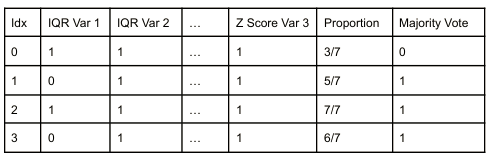

- Evaluate the model using appropriate evaluation metrics and explain the insights you got from evaluation metrics analysis.



## IQR method

I will use these variables: step, amount, oldbalanceOrg, and newbalanceOrig.

In [28]:
iqr_vars = df_train[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig']]
q1 = iqr_vars.quantile(0.25)
q3 = iqr_vars.quantile(0.75)
iqr = q3 - q1
iqr_min = q1 - iqr
iqr_max = q3 + iqr

iqr_votes = (iqr_vars < iqr_min) | (iqr_vars > iqr_max)
iqr_votes.columns = 'IQR_' + iqr_votes.columns
iqr_votes

,IQR_step,IQR_amount,IQR_oldbalanceOrg,IQR_newbalanceOrig
5407,False,False,False,False
2977,False,False,False,False
2209,False,False,False,False
13865,False,False,False,False
19230,False,False,False,False
...,...,...,...,...
12830,False,False,False,False
19607,False,False,False,False
10701,True,False,False,False
16740,False,False,False,False


## Z-score method

In [29]:
z_vars = df_train[['step', 'amount', 'oldbalanceOrg']]
z_vars = (z_vars - z_vars.mean()) / z_vars.std()
z_votes = (z_vars < -2) | (z_vars > 2)
z_votes.columns = 'Z_' + z_votes.columns
z_votes

,Z_step,Z_amount,Z_oldbalanceOrg
5407,False,False,False
2977,False,False,False
2209,False,False,False
13865,False,False,False
19230,False,False,False
...,...,...,...
12830,False,False,False
19607,False,False,False
10701,True,False,False
16740,False,False,False


## Summary results

In [30]:
outlier_votes = pd.concat([iqr_votes, z_votes], axis=1)
outlier_votes['vote'] = outlier_votes.mean(axis=1)
outlier_votes['isOutlier'] = outlier_votes['vote'] > 0.5
outlier_votes

,IQR_step,IQR_amount,IQR_oldbalanceOrg,IQR_newbalanceOrig,Z_step,Z_amount,Z_oldbalanceOrg,vote,isOutlier
5407,False,False,False,False,False,False,False,0.000000,False
2977,False,False,False,False,False,False,False,0.000000,False
2209,False,False,False,False,False,False,False,0.000000,False
13865,False,False,False,False,False,False,False,0.000000,False
19230,False,False,False,False,False,False,False,0.000000,False
...,...,...,...,...,...,...,...,...,...
12830,False,False,False,False,False,False,False,0.000000,False
19607,False,False,False,False,False,False,False,0.000000,False
10701,True,False,False,False,True,False,False,0.285714,False
16740,False,False,False,False,False,False,False,0.000000,False


How often do outlier occurs?

In [31]:
outlier_votes['isOutlier'].mean()

0.003214974637422305

It's very rare, so we cannot really use it to detect frauds. However, the occurence of frauds are very high in those observations:

In [32]:
df_train[outlier_votes['isOutlier']]['isFraud'].mean()

0.7777777777777778

(Fraud occur 78% of the time in the outliers.)

Alternatively, we can label observations with any indication of outlier from any of the variables. As expected, they happen more often (8% of the time):

In [33]:
(outlier_votes['vote'] > 0).mean()

0.08844752446952918

And yet, the occurence of fraud is still pretty high (30%):

In [34]:
df_train[outlier_votes['vote'] > 0]['isFraud'].mean()

0.30290791599353795

Let's store the prediction for later use.

In [35]:
y_train_pred_outlier = (outlier_votes['vote'] > 0).astype(int)

## Insights

While large percentage of the outlier observations are frauds, the opposite is not true; there are still many more cases of frauds that are not outliers.

# Question 5: K-means clustering

Fraudulent transactions often behave differently from normal transactions. **K-Means clustering** groups similar transactions together, helping us detect anomalies.

Your task:
- Perform **K-Means clustering** on the dataset.
- Identify the cluster with the most extreme outliers and label them as fraud.
- Visualize the clusters using scatter plots or **PCA (Principal Component Analysis)**.
- Explain the insights you got from detecting fraud using the clustering method.

We first need to (1) apply one-hot encoding to categorical variables, and (2) standardize the variable to have mean=0 and stdev=1.

## Data preprocessing

In [36]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

def fit_ohe(df: pd.DataFrame, cat_cols: list[str]) -> OneHotEncoder:
    '''
    Fit one-hot encoder for the categorical columns

    Parameters
    ----------
    df: pd.DataFrame
    cat_cols: list of str
        Name of categorical columns

    Returns
    -------
    OneHotEncoder object
    '''
    ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse_output=False)
    ohe.fit(df[cat_cols])
    return ohe

def transform_ohe(df: pd.DataFrame, ohe: OneHotEncoder) -> pd.DataFrame:
    '''
    Transform the categorical columns using one-hot encoder

    Parameters
    ----------
    df: pd.DataFrame
    ohe: fitted OneHotEncoder object

    Returns
    -------
    pd.DataFrame
    '''
    cat_cols = ohe.feature_names_in_
    df = df.copy()
    df_ohe = pd.DataFrame(
        ohe.transform(df[cat_cols]),
        index=df.index,
        columns=ohe.get_feature_names_out()
    )
    df = pd.concat([df, df_ohe], axis=1)
    df = df.drop(cat_cols, axis=1)
    return df

def fit_scaler(df: pd.DataFrame) -> StandardScaler:
    '''
    Fit a standard scaler on all columns

    Parameters
    ----------
    df: pd.DataFrame

    Returns
    -------
    StandardScaler object
    '''
    scaler = StandardScaler()
    scaler.fit(df)
    return scaler

def transform_scaler(df: pd.DataFrame, scaler: StandardScaler) -> pd.DataFrame:
    '''
    Transform data using a standard scaler

    Parameters
    ----------
    df: pd.DataFrame
    scaler: fitted StandardScaler object

    Returns
    -------
    pd.DataFrame
    '''
    return pd.DataFrame(
        scaler.transform(df),
        index=df.index,
        columns=df.columns
    )

def preprocess_data(
    X: pd.DataFrame,
    ohe: OneHotEncoder,
    scaler: StandardScaler,
) -> pd.DataFrame:
    '''
    Preprocess data from start to finish
    '''
    X = X.copy()
    X = transform_ohe(X, ohe)
    X = transform_scaler(X, scaler)
    return X

In [37]:
cat_vars = ['type']
ohe = fit_ohe(X_train, cat_vars)
X_train_ohe = transform_ohe(X_train, ohe)
scaler = fit_scaler(X_train_ohe)

X_train_clean = preprocess_data(X_train, ohe, scaler)
X_valid_clean = preprocess_data(X_valid, ohe, scaler)
X_test_clean = preprocess_data(X_test, ohe, scaler)

## Clustering

In [38]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [39]:
def calc_outlier_factor(kmeans, X):
    clusters = kmeans.predict(X)
    ds = (X - kmeans.cluster_centers_[clusters])
    dnorm = ds.apply(lambda row: np.linalg.norm(row), axis=1)
    dmax = dnorm.max()
    outlier_factor = dnorm / dmax
    return outlier_factor

def kmeans_pred(kmeans, X, thresh):
    outlier_factor = calc_outlier_factor(kmeans, X)
    y_pred = (outlier_factor > thresh).astype(int)
    return y_pred

In [40]:
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_train_clean)
outlier_factor = calc_outlier_factor(kmeans, X_train_clean)
kmeans_threshold = np.quantile(outlier_factor, 0.95)

In [41]:
y_train_pred_kmeans = kmeans_pred(kmeans, X_train_clean, kmeans_threshold)
y_valid_pred_kmeans = kmeans_pred(kmeans, X_valid_clean, kmeans_threshold)

In [42]:
X_train_pca = PCA(n_components=2).fit_transform(X_train_clean)
X_train_pca = pd.DataFrame(X_train_pca, index=X_train.index, columns=['x', 'y'])
X_train_pca['fraud'] = y_train
X_train_pca['cluster'] = pd.Categorical(kmeans.labels_)

<Axes: xlabel='x', ylabel='y'>

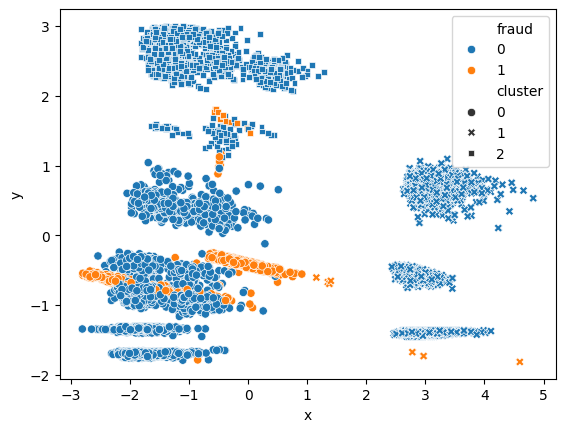

In [43]:
sns.scatterplot(X_train_pca, x='x', y='y', style='cluster', hue='fraud')

Observation: the fraudulent transactions are still located close to non-fraudulent transactions, so the classifier would probably perform poorly.

# Question 6: model evaluations

Once we have built fraud detection models, we need to evaluate their effectiveness. Different models may have trade-offs between catching fraud and avoiding false alarms.

Your Task is to compare the fraud detection models built so far (**statistical, K-Means**). Use the following metrics:
- **Precision** (How many predicted fraud cases are actually fraud?)
- **Recall** (How many actual fraud cases did we catch?)
- **F1-score** (Balance between precision and recall)
- Explain the result of the **strengths and weaknesses of each approach**.



In [44]:
def eval_model(y_true, y_pred):
    return {
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred)
    }

In [45]:
summary_q6 = pd.DataFrame({
    'statistical': eval_model(y_train, y_train_pred_outlier),
    'kmeans': eval_model(y_train, y_train_pred_kmeans),
}).T
summary_q6

,precision,recall,f1
statistical,0.302908,0.383436,0.338448
kmeans,0.724286,0.518405,0.604291


Based on the above result, the kmeans method result in better performance across the metrics

# Question 7: ensemble models

Ensemble models combine multiple models to make a better prediction. Instead of relying on just one method (e.g., statistical approach or K-Means), combine different models and take a **majority vote** to decide if a transaction is fraud.

### Model 1: Ensemble fraud detection model using statistical method only
- Use **3 variables** with the highest predictive power and apply **IQR method** for each variable.
- Create a summary table and perform a majority vote.

    Example of the result:

    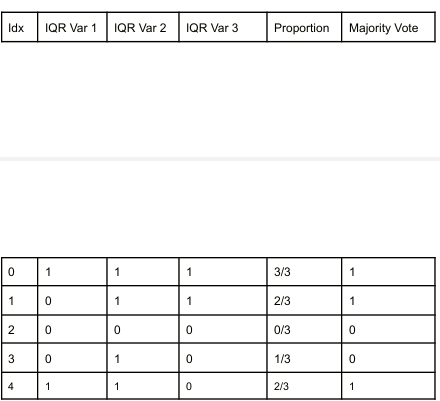

- Evaluate the model using appropriate evaluation metrics.

### Model 2: Ensemble fraud detection model using statistical method only
- Use **3 variables** with the highest predictive power and apply **Z-Score method** for each variable.
- Create a summary table and perform a majority vote.

Example of the result:

  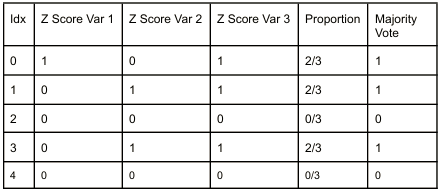

- Evaluate the model using appropriate evaluation metrics.

### Model 3: Ensemble fraud detection model combining **Statistical methods (IQR, Z-score) and Clustering methods (K-Means)**
- Define a **decision rule**: If the majority of models classify a transaction as fraud, label it as fraud.
- Example of the result:

    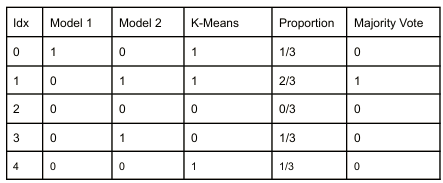

- Evaluate the model using appropriate evaluation metrics.

### Compare Models
Test which model performs better than other models.
- Compare the result of **Model 1 and Model 2 (ensemble model from statistical approach only) vs Model 3 (ensemble model combining statistical and clustering methods).**
- Example of the table of comparison:

  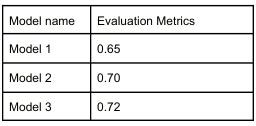

Note: instead of doing a majority vote, I decide that it'd be better to predict "1" if any of the classifier predict "1". If we do majority vote, the model would very rarely classify as "1".

In [46]:
from sklearn.base import BaseEstimator

class ZScoreModel(BaseEstimator):
    def __init__(
        self, *,
        num_vars: list[str],
        upper_threshold: float | None = None,
        lower_threshold: float | None = None,
    ):
        self.num_vars = num_vars
        if upper_threshold is None:
            upper_threshold = 999
        if lower_threshold is None:
            lower_threshold = -999
        self.upper_threshold = upper_threshold
        self.lower_threshold = lower_threshold

    def fit(self, X, y):
        self.is_fitted_ = True

        self.mus = X[self.num_vars].mean()
        self.stds = X[self.num_vars].std()

        return self

    def predict(self, X):
        X_num = X[self.num_vars]
        Z = (X_num - self.mus) / self.stds
        votes = ((Z > self.upper_threshold) | (Z < self.lower_threshold)).mean(axis=1)
        is_fraud = (votes > 0.).astype(int)
        y_pred = is_fraud.astype(int)
        return y_pred

class IQRModel(BaseEstimator):
    def __init__(
        self, *,
        num_vars: list[str],
    ):
        self.num_vars = num_vars

    def fit(self, X, y):
        self.is_fitted_ = True
        self.y_prior = (y == 1).mean()

        q1 = X[self.num_vars].quantile(0.25)
        q3 = X[self.num_vars].quantile(0.75)
        iqr = q3 - q1
        self.lbound = q1 - 1.5 * iqr
        self.ubound = q3 + 1.5 * iqr
        return self

    def predict(self, X):
        X_num = X[self.num_vars]
        votes = ((X_num > self.ubound) | (X_num < self.lbound)).mean(axis=1)
        is_fraud = (votes > 0.).astype(int)
        return is_fraud

In [47]:
zscore_model = ZScoreModel(num_vars=['step', 'amount', 'oldbalanceOrg'], upper_threshold=1.5)
zscore_model.fit(X_train, y_train)

iqr_model = IQRModel(num_vars=['step', 'amount', 'oldbalanceOrg'])
iqr_model.fit(X_train, y_train);

In [48]:
y_train_preds = pd.DataFrame({
    'zscore': zscore_model.predict(X_train), 
    'iqr': iqr_model.predict(X_train), 
    'kmeans': y_train_pred_kmeans
})
y_train_preds['combined'] = (y_train_preds > 0).any(axis=1).astype(int)
y_train_preds

,zscore,iqr,kmeans,combined
5407,0,0,0,0
2977,0,0,0,0
2209,0,0,0,0
13865,0,0,0,0
19230,0,0,0,0
...,...,...,...,...
12830,0,0,0,0
19607,0,0,0,0
10701,1,1,0,1
16740,1,0,0,1


In [49]:
summary_q7 = \
    pd.DataFrame({col: eval_model(y_train, y_train_preds[col]) for col in y_train_preds.columns}).T

summary_q7

,precision,recall,f1
zscore,0.379764,0.560327,0.452705
iqr,0.375676,0.142127,0.206231
kmeans,0.724286,0.518405,0.604291
combined,0.420187,0.783231,0.546948


If we go by the F1 score, the kmeans model is still the best among the other models.

# Question 8: ROI simulations

Make a simulation on cost and **ROI (Return on Investment)** based on this condition:
- You proposed a fraud detection model to minimize fraud losses based on the best model obtained from the previous step.
- Beyond cost savings, you must also consider **benefits, model ownership costs, and fraud handling costs**.
- **ROI is calculated** as the ratio of **net profit (benefit minus costs) to total investment**, expressed as a percentage.
- **Total utility** is defined as the difference between **benefits and costs**, representing the **net return**.

### Costs:
- **False Negatives (FN)**: Fraud loss, represented by the corresponding transaction amount for ignored fraud cases.
- **False Positives (FP)**: Losses from profit and customer acquisition costs, including:
  - **30,000** for acquisition.
  - **70,000** for profit loss per false positive.

### Benefits:
- **True Positives (TP)**: Prevented fraud losses, represented by corresponding transaction amount.
- **True Negatives (TN)**: Generated profit of **70,000** from legitimate transactions.

### Total Cost of Ownership:
- **500,000,000** for software, hardware, security, and development.
- **300,000,000** for migration, setup, monitoring, and support.

### Total Cost of Fraud Handling:
- Fraud handling cost per transaction: **200,000**.
- Legal cost: **5,000,000**.


Remember: ROI = total utility / (total cost of ownership + total cost of fraud handling)

In [50]:
def calc_total_utility(y_true: pd.Series, y_pred: pd.Series, exp_fraud_loss: pd.Series) -> float:
    profit_per_trx = 70e3
    acquisition_cost = 30e3

    fp = (y_pred == 1) & (y_true == 0)
    fn = (y_pred == 0) & (y_true == 1)

    # cost of accepting fraudulent claims
    fn_cost = (fn * exp_fraud_loss).sum()

    # cost of not accepting valid claims
    fp_cost = (fp * (acquisition_cost + profit_per_trx)).sum()
    cost = fp_cost + fn_cost

    tp = (y_true == 1) & (y_pred == 1)
    tn = (y_true == 0) & (y_pred == 0)

    tp_benefit = (tp * exp_fraud_loss).sum()
    tn_benefit = (tn * profit_per_trx).sum()

    total_benefit = tp_benefit + tn_benefit

    total_utility = total_benefit - cost
    return total_utility

def calc_roi(y_true: pd.Series, y_pred: pd.Series, exp_fraud_loss: pd.Series):
    total_utility = calc_total_utility(y_true, y_pred, exp_fraud_loss)
    tco = 500e6 + 300e6 # acquisition + operation costs

    legal_cost = 5e6
    # calculate fraud handling cost for every transactin we predict as frauds
    fraud_handling_cost = 200e3
    total_fraud_handling_cost = (y_pred * fraud_handling_cost).sum()

    roi = total_utility / (tco + total_fraud_handling_cost + legal_cost)

    return roi

In [51]:
calc_roi(y_train, y_train_pred_kmeans, X_train['amount'])

0.9296512570759567

Based on the given specifications, the model will result in 93% ROI. This number is very high due to discrepancy in the transacted amounts (which range from 0 to 20) while the profit generated per transaction is 70,000.